In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deap

     |████████████████████████████████| 163kB 16.7MB/s 


In [ ]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score,accuracy_score
# run block of code and catch warnings
import warnings
# with warnings.catch_warnings():
# 	# ignore all caught warnings
# 	warnings.filterwarnings("ignore")
# 	# execute code that will generate warnings
# 	...
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install deap

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/COVID19/Covid-19 Dataset_Clinical Data/cleaned_ISRdataset_train_final1 - cleaned_ISRdataset_train_final1.csv')

In [ ]:
df_test= pd.read_csv('/content/drive/MyDrive/COVID19/Covid-19 Dataset_Clinical Data/cleaned_ISRdataset_test_finale - cleaned_ISRdataset_test_finale.csv')

In [ ]:
X_train=df_train.values[:,0:8]
y_train=df_train.values[:,8]

In [ ]:
X_test=df_test.values[:,0:8]
y_test=df_test.values[:,8]

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  

Before OverSampling, counts of label '1': 4769
Before OverSampling, counts of label '0': 47062 



In [ ]:
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE() 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

After OverSampling, the shape of train_X: (94124, 8)
After OverSampling, the shape of train_y: (94124,) 

After OverSampling, counts of label '1': 47062
After OverSampling, counts of label '0': 47062


In [ ]:
feat_cols = [2,3,4,5,6,7]

gen	nevals	avg     	std      	min     	max     
0  	100   	0.920231	0.0434053	0.490601	0.943841
1  	88    	0.924967	0.00517819	0.923546	0.943841
2  	95    	0.925718	0.00657683	0.923546	0.95095 
3  	88    	0.926447	0.00762433	0.923546	0.953419
4  	96    	0.928797	0.00946835	0.923546	0.953419
5  	93    	0.930766	0.0104379 	0.923546	0.953419
6  	89    	0.934987	0.0114645 	0.923546	0.953419
7  	92    	0.939602	0.0104266 	0.923546	0.955592
8  	95    	0.944325	0.00694619	0.923546	0.955592
9  	96    	0.947573	0.00455506	0.923546	0.955592
10 	87    	0.948515	0.00561295	0.923546	0.955592


([<matplotlib.axis.XTick at 0x7fd65770cbd0>,
 <a list of 5 Text major ticklabel objects>)

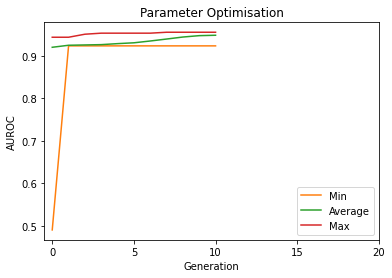

In [ ]:
def mutate(individual):
    
    gene = random.randint(0,9) #select which parameter to mutate
    if gene == 0:
        if individual[0] == 'gini':
            individual[0] = 'entropy'
        else:
            individual[0] = 'gini'
        
    elif gene == 1:
        if individual[1] == 'best':
            individual[1] = 'random'
        else:
            individual[1] = 'best'
    
    elif gene == 2:
        individual[2] = random.randint(lower_depth, upper_depth)
        
    elif gene in [4,5]:
        individual[gene] = random.uniform(lower_samples_leaf, upper_samples_leaf)
    
    elif gene == 6:
        individual[6] = random.uniform(lower_n_learning, upper_n_learning)

    elif gene in [3,8]:
        individual[gene] = random.random()
        
    elif gene == 7:
        individual[7] = random.randint(lower_n_estimators, upper_n_estimators)
        
    elif gene == 9:
        if individual[9] == 'balanced':
            individual[9] = None
        else:
            individual[9] = 'balanced'        

    return individual,


def evaluate(individual):
    '''
    build and test a model based on the parameters in an individual and return
    the AUROC value
    '''
    # extract the values of the parameters from the individual chromosome
    crit = individual[0]
    split = individual[1]
    depth = individual[2]
    samples_split = individual[3]
    samples_leaf = individual[4]
    weight_fraction_leaf = individual[5]
    learning_rate = individual[6]
    n_estimator = individual[7]
    impurity_decrease = individual[8]
    class_weight = individual[9]
    # build the model
    model =  AdaBoostClassifier(DecisionTreeClassifier(criterion=crit, 
                                   splitter=split, 
                                   max_depth=depth, 
                                   min_samples_split=samples_split, 
                                   min_samples_leaf=samples_leaf, 
                                   min_weight_fraction_leaf=weight_fraction_leaf, 
                                   random_state=100, 
                                   min_impurity_decrease=impurity_decrease, class_weight=class_weight, 
                                   presort=False), n_estimators=n_estimator, learning_rate=learning_rate).fit(X_train_res[:,feat_cols], y_train_res)
    probs = model.predict(X_test[:,feat_cols])
    roc_auc=accuracy_score(y_test, probs)
     
    


    
    # fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    # roc_auc = metrics.auc(fpr, tpr)
    return roc_auc,

    


creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Maximise the fitness function value
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Possible parameter values
criterions = ['gini', 'entropy']
splits = ['best', 'random']

lower_depth, upper_depth = 2, 12 
lower_leaf_nodes, upper_leaf_nodes = 2, 100
class_weight = ['balanced', None]
lower_samples_leaf, upper_samples_leaf  = 0, 0.5
lower_n_estimators, upper_n_estimators=50,1000
lower_n_learning,upper_n_learning=0.1,1

N_CYCLES = 1

toolbox.register("attr_crit", random.choice, criterions)
toolbox.register("attr_splitter", random.choice, splits)
toolbox.register("attr_depth", random.randint, lower_depth, upper_depth)
toolbox.register("attr_flt", random.random)
toolbox.register("attr_leaf_nodes", random.randint, lower_leaf_nodes, upper_leaf_nodes)
toolbox.register("attr_weight", random.choice, class_weight)
toolbox.register("attr_samples_leaf", random.uniform, lower_samples_leaf, upper_samples_leaf)


toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_crit, toolbox.attr_splitter, toolbox.attr_depth,
                 toolbox.attr_flt, toolbox.attr_samples_leaf, toolbox.attr_samples_leaf, 
                 toolbox.attr_flt, toolbox.attr_leaf_nodes,
                 toolbox.attr_flt, toolbox.attr_weight), n=N_CYCLES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate",mutate)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("evaluate", evaluate)

population_size = 100
crossover_probability = 0.9
mutation_probability = 0.1
number_of_generations = 10

pop = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=crossover_probability, stats = stats, 
                               mutpb = mutation_probability, ngen=number_of_generations, halloffame=hof, 
                               verbose=True) 

best_parameters = hof[0] # save the optimal set of parameters

best_parameters



gen = log.select("gen")
max_ = log.select("max")
avg = log.select("avg")
min_ = log.select("min")

evolution = pd.DataFrame({'Generation': gen,
                         'Max AUROC': max_,
                          'Average':avg,
                         'Min AUROC': min_})

plt.title('Parameter Optimisation')
plt.plot(evolution['Generation'], evolution['Min AUROC'], 'b', color = 'C1',
         label = 'Min')
plt.plot(evolution['Generation'], evolution['Average'], 'b', color = 'C2',
         label = 'Average')
plt.plot(evolution['Generation'], evolution['Max AUROC'], 'b', color = 'C3',
         label= 'Max')


plt.legend(loc = 'lower right')
plt.ylabel('AUROC')
plt.xlabel('Generation')
plt.xticks([0,5,10,15,20])


In [ ]:
best_parameters

['entropy',
 'best',
 11,
 0.5418569025746448,
 0.041772137625606,
 0.06212417979747642,
 0.8623143995876397,
 99,
 0.021862996980991256,
 None]